# Imports

In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Read data

In [2]:
# Broken battery
# data_path = "./data/prius/2025-05-05 16-36-54.csv"
# data_path = "./data/prius/2025-05-06 11-04-19.csv"
# data_path = "./data/prius/2025-05-06 16-44-49.csv"

# data_path = "./data/prius/2025-05-07 13-49-12.csv"
# data_path = "./data/prius/2025-05-07 14-09-28.csv"

# Fixed battery
# data_path = "./data/prius/2025-05-07 19-47-01.csv"
# data_path = "./data/prius/2025-05-07 20-08-29.csv"

# data_path = "./data/prius/2025-05-07 21-50-31.csv"
# data_path = "./data/prius/2025-05-07 21-59-02.csv"

# data_path = "./data/prius/2025-05-08 08-39-35.csv"
data_path = "./data/prius/2025-05-08 13-05-48.csv"

data = pd.read_csv(data_path)

# Extract columns

In [3]:
blocks = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14"]
columns = (["time"] +
           ["HV Battery Block-{} Voltage (V)".format(block) for block in blocks] +
           ["Internal Resistance R{} (mOhm)".format(block) for block in blocks])

In [4]:
# Extract
data = data[[col for col in columns if col in data.columns]].copy()
# Transform time
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S.%f')

# Voltages

In [5]:
df = data[["time"] + [col for col in data.columns if "Voltage" in col]]
df = df.dropna(axis=0, subset=[col for col in df.columns if "Voltage" in col], how='all').copy()

# Block voltages

In [6]:
df_melted = df.melt(id_vars="time", var_name="Block #", value_name="Voltage")
df_melted["Block #"] = df_melted["Block #"].apply(lambda x: x.split(' ')[-3].split('-')[-1])

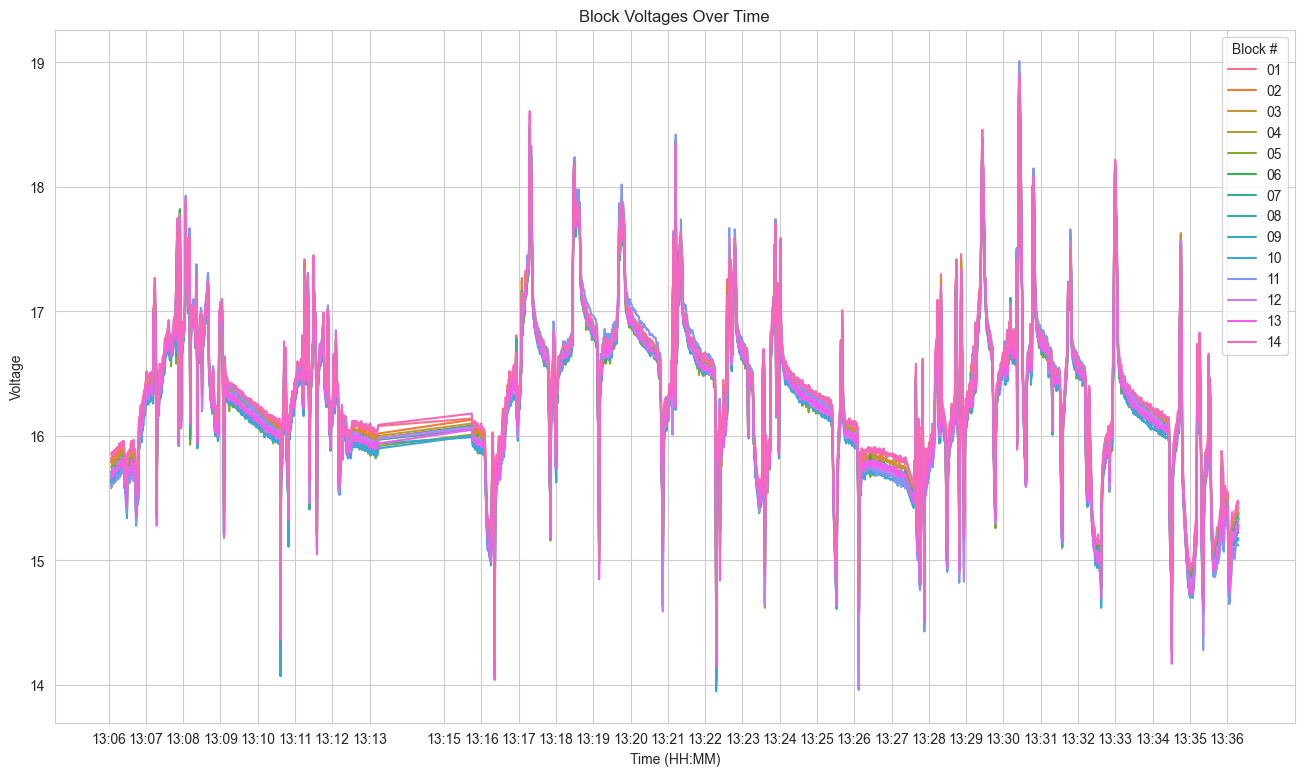

In [7]:
fig = plt.figure(figsize=(16, 9))
sns.lineplot(data=df_melted, x='time', y='Voltage', hue='Block #')

# Get the unique minute timestamps
minute_ticks = df['time'].dt.floor('min').drop_duplicates()
N = 1  # show every minute
minute_ticks = minute_ticks[::N]
plt.xticks(ticks=minute_ticks, labels=minute_ticks.dt.strftime('%H:%M'))

plt.xlabel("Time (HH:MM)")
plt.ylabel("Voltage")
plt.title("Block Voltages Over Time")
plt.legend(title="Block #")
plt.grid(True)
plt.show()

## Difference between highest and lowest voltages

In [8]:
df["∆ Voltage"] = (df.max(axis = 1, numeric_only=True) - df.min(axis = 1, numeric_only=True))
df["∆ Voltage"] = df["∆ Voltage"].round(2)

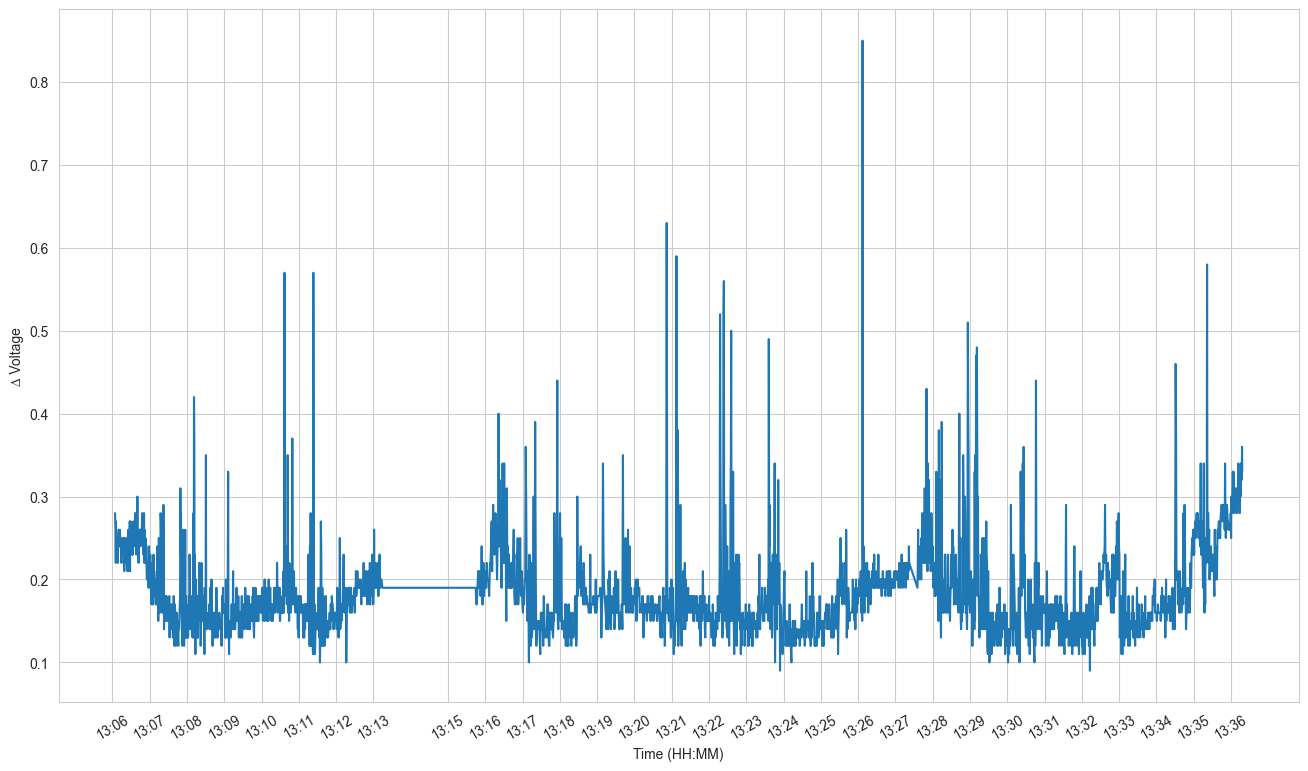

In [9]:
fig = plt.figure(figsize=(16, 9))
sns.lineplot(data=df, x="time", y="∆ Voltage")

# Get the unique minute timestamps
minute_ticks = df['time'].dt.floor('min').drop_duplicates()
N = 1  # show every minute
minute_ticks = minute_ticks[::N]
plt.xticks(ticks=minute_ticks, labels=minute_ticks.dt.strftime('%H:%M'), rotation=30)

plt.xlabel("Time (HH:MM)")
plt.grid(True)
plt.show()

## Average block voltage

In [10]:
averages = df[[col for col in df.columns if "Block" in col]].mean().reset_index()
averages.columns = ["Block #", "Average Voltage"]
averages["Block #"] = averages["Block #"].apply(lambda x: x.split(' ')[-3].split('-')[-1])

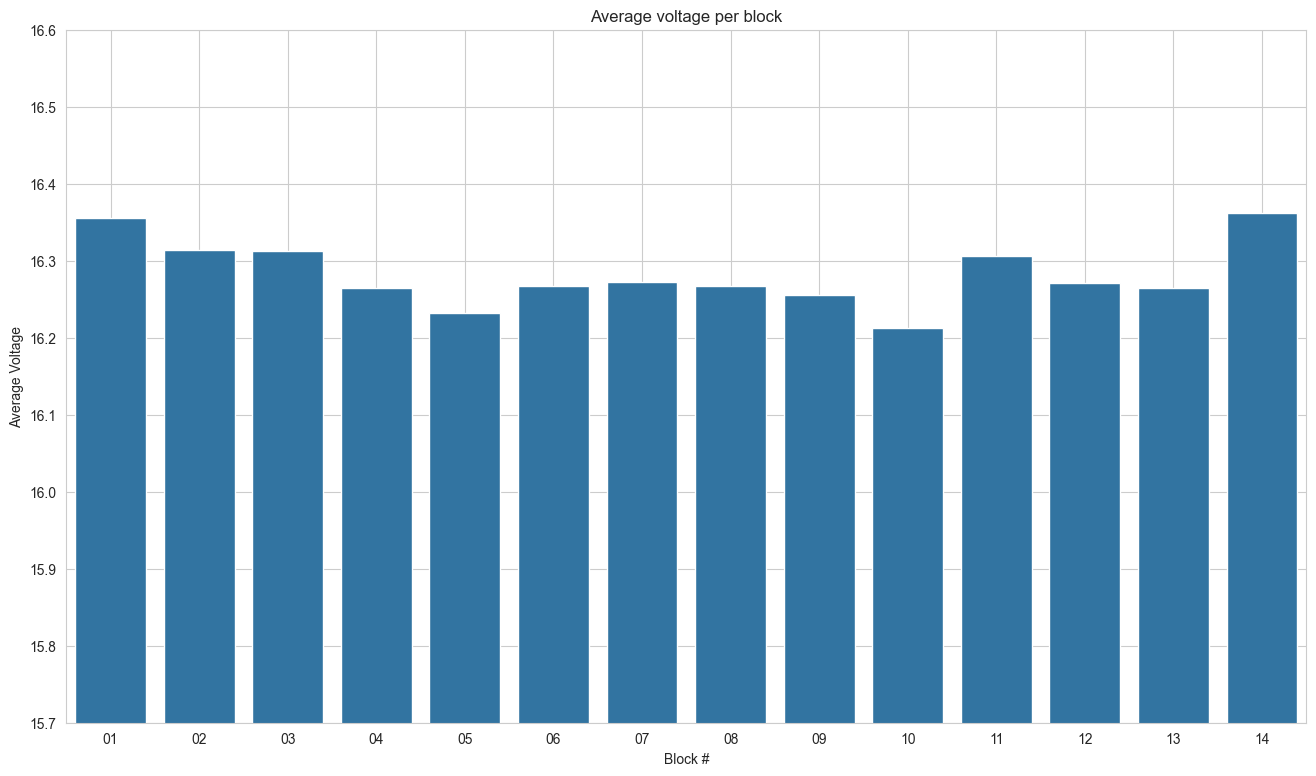

In [11]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(data=averages, x="Block #", y="Average Voltage")

ymin = averages["Average Voltage"].min() - 0.5
ymax = averages["Average Voltage"].max() + 0.2
plt.ylim(ymin, ymax)
plt.yticks(np.arange(round(ymin, 1), round(ymax, 1), 0.1))

plt.title("Average voltage per block")
plt.ylabel("Average Voltage")
plt.xlabel("Block #")
plt.grid(True)
plt.show()

# Block resistance

In [12]:
df = data[["time"] + [col for col in data.columns if "Resistance" in col]]
df = df.dropna(axis=0, subset=[col for col in df.columns if "Resistance" in col], how='all').copy()

In [13]:
# Group columns that have exactly the same values across all rows
def group_identical_columns(df: pd.DataFrame) -> defaultdict[str, list]:
    col_groups = defaultdict(list)
    checked = set()
    for col_i in df.columns:
        if col_i in checked:
            continue
        group = [col_i]
        for col_j in df.columns:
            if col_j != col_i and col_j not in checked:
                if df[col_i].equals(df[col_j]):
                    group.append(col_j)
        for gcol in group:
            checked.add(gcol)
        col_groups[col_i] = group
    return col_groups

identical_groups = group_identical_columns(df.drop(columns=['time']))
df_grouped = df.copy()
for repeated_col, cols in identical_groups.items():
    # Extract block number
    label = ', '.join([col.split(' ')[-2][1:] for col in cols])
    # Take the first repeated column as the representative for that group
    df_grouped[label] = df[repeated_col]
    # Drop the original redundant columns
    df_grouped.drop(columns=cols, inplace=True)

# Melt for plotting or analysis
df_grouped_melted = df_grouped.melt(id_vars='time', var_name='Blocks', value_name='Value')

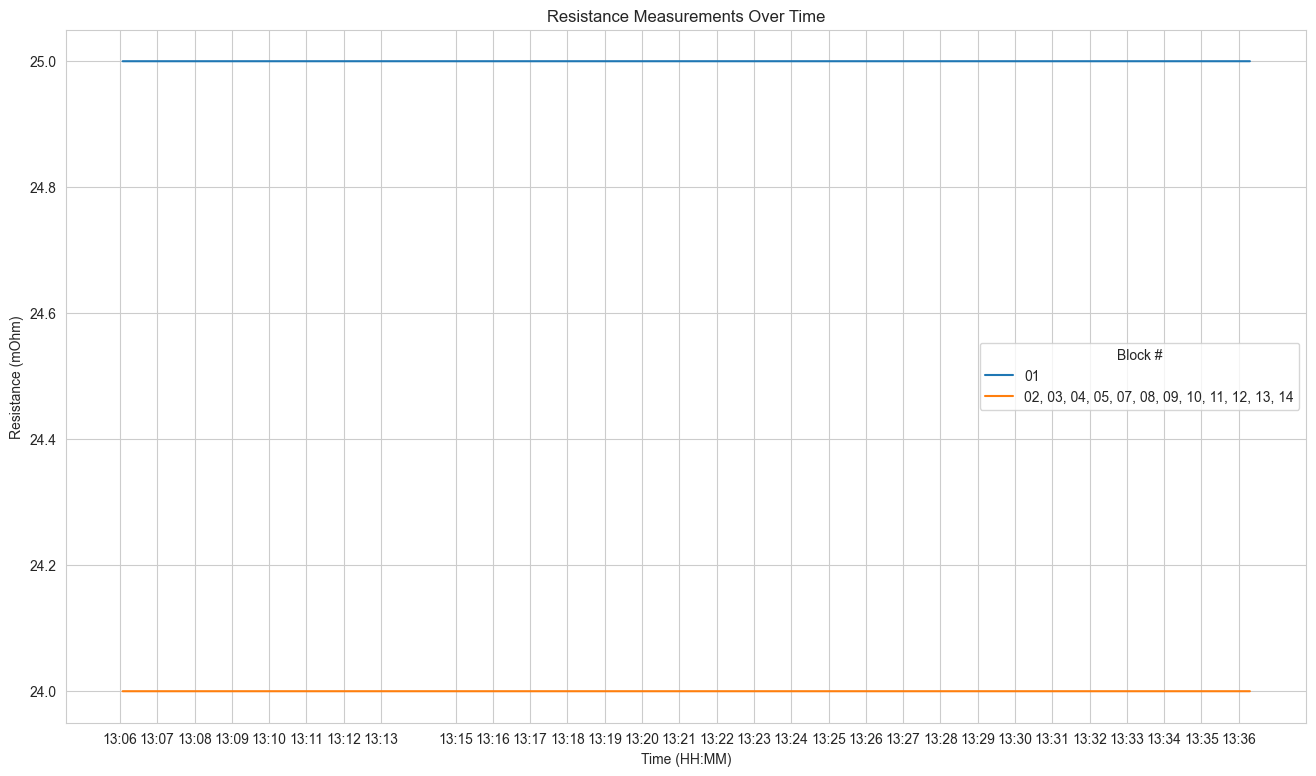

In [14]:
fig = plt.figure(figsize=(16, 9))
sns.lineplot(data=df_grouped_melted, x='time', y='Value', hue='Blocks')

# Get the unique minute timestamps
minute_ticks = df['time'].dt.floor('min').drop_duplicates()
N = 1  # show every minute
minute_ticks = minute_ticks[::N]
plt.xticks(ticks=minute_ticks, labels=minute_ticks.dt.strftime('%H:%M'))

plt.xlabel("Time (HH:MM)")
plt.ylabel("Resistance (mOhm)")
plt.title("Resistance Measurements Over Time")
plt.legend(title="Block #")
plt.grid(True)
plt.show()